In [2]:
# installing catboost since it is not readily available in Google Colab
!pip3 install catboost


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.3 MB/s 


In [3]:
! pip install xverse
! pip install --upgrade category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 710 kB/s 


In [4]:
# to show the time taken by each cell 
!pip install ipython-autotime
%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 4.0 MB/s 
time: 485 µs (started: 2022-11-23 16:27:14 +00:00)


In [5]:

import numpy as np
import pandas as pd

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns

from xverse.transformer import WOE
from category_encoders.cat_boost import CatBoostEncoder
from category_encoders.woe import WOEEncoder

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay
from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.feature_selection import RFE

time: 1.89 s (started: 2022-11-23 16:27:14 +00:00)


In [29]:
# importing required libraries

%matplotlib inline

import pandas as pd
from catboost import CatBoostClassifier
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay, f1_score, RocCurveDisplay, roc_auc_score, accuracy_score, classification_report, recall_score
from sklearn.model_selection import train_test_split

time: 4.89 ms (started: 2022-11-23 16:28:08 +00:00)


# About the Dataset
---
## Insurance Claim Prediction
---

1. An insurance policy is an agreement between a company and a customer by which a company undertakes to provide a guarantee of compensation for specified loss, damage or illness in return for the payment of a specified premium. A premium is a sum of money that the customer needs to pay regularly to an insurance company for this guarantee.

2. For example, you pay a premium of Rs. 3000/- each year for car insurance with a coverage of Rs. 100,000/-. Unfortunately, in case of an accident, the car is severely damaged. In that case, the insurance provider company will bear the cost of damage etc. for up to Rs. 100,000. 

3. Now if you are wondering how can a company bear such a high cost when it charges a premium of only Rs. 3000/- per year only i.e. where the concept of probability comes into the picture. For example, there might be thousands of customers who would be paying a premium of Rs. 3000 every year just like you, but only a few of them (say 2-3) would have had an accident that year and not everyone. This way everyone shares the risk of everyone else.

4. Our client is an Insurance company that provides insurance for cars to its customers. In this hackathon, you will be closely working with the insurer in understanding the behaviour of the policyholders.

In [30]:
# to display all the rows and columns
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

time: 1.07 ms (started: 2022-11-23 16:28:08 +00:00)


In [103]:
df = pd.read_csv('train_qWM28Yl.csv')
oot = pd.read_csv('test_zo1G9sv.csv')

time: 557 ms (started: 2022-11-23 16:45:04 +00:00)


In [32]:
# checking for any duplicate policy IDs
df['policy_id'].duplicated().sum()

0

time: 16.6 ms (started: 2022-11-23 16:28:08 +00:00)


In [33]:
df.head()

,policy_id,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,segment,model,fuel_type,max_torque,max_power,engine_type,airbags,is_esc,is_adjustable_steering,is_tpms,is_parking_sensors,is_parking_camera,rear_brakes_type,displacement,cylinder,transmission_type,gear_box,steering_type,turning_radius,length,width,height,gross_weight,is_front_fog_lights,is_rear_window_wiper,is_rear_window_washer,is_rear_window_defogger,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,is_claim
0,ID00001,0.515874,0.05,0.644231,C1,4990,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2,No,No,No,Yes,No,Drum,796,3,Manual,5,Power,4.6,3445,1515,1475,1185,No,No,No,No,No,No,No,Yes,No,No,No,Yes,0,0
1,ID00002,0.672619,0.02,0.375000,C2,27003,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2,No,No,No,Yes,No,Drum,796,3,Manual,5,Power,4.6,3445,1515,1475,1185,No,No,No,No,No,No,No,Yes,No,No,No,Yes,0,0
2,ID00003,0.841110,0.02,0.384615,C3,4076,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2,No,No,No,Yes,No,Drum,796,3,Manual,5,Power,4.6,3445,1515,1475,1185,No,No,No,No,No,No,No,Yes,No,No,No,Yes,0,0
3,ID00004,0.900277,0.11,0.432692,C4,21622,1,C1,M2,Petrol,113Nm@4400rpm,88.50bhp@6000rpm,1.2 L K12N Dualjet,2,Yes,Yes,No,Yes,Yes,Drum,1197,4,Automatic,5,Electric,4.8,3995,1735,1515,1335,Yes,No,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2,0
4,ID00005,0.596403,0.11,0.634615,C5,34738,2,A,M3,Petrol,91Nm@4250rpm,67.06bhp@5500rpm,1.0 SCe,2,No,No,No,No,Yes,Drum,999,3,Automatic,5,Electric,5.0,3731,1579,1490,1155,No,No,No,No,No,Yes,Yes,Yes,No,Yes,Yes,Yes,2,0


time: 45.6 ms (started: 2022-11-23 16:28:08 +00:00)


## Description of each column:
---
| Variable | Description |
| ---: | :--- |
| `policy_id` | Unique identifier of the policyholder |
| `policy_tenure`| Time period of the policy |
| `age_of_car` | Normalized age of the car in years | 
| ` age_of_policyholder`| Normalized age of policyholder in years |
|`area_cluster`| 	Area cluster of the policyholder|
| `population`| Population density of the city (Policyholder City) |
| `make` | Encoded Manufacturer/company of the car |
| `segment` | Segment of the car (A/ B1/ B2/ C1/ C2) |
| `model`| Encoded name of the car|
|`fuel_type` | Type of fuel used by the car|
|`max_torque`| Maximum Torque generated by the car (Nm@rpm)|
| `max_power`| Maximum Power generated by the car (bhp@rpm) |
|`engine_type`| Type of engine used in the car|
|`engine_type`| Type of engine used in the car|
|`airbags`|Number of airbags installed in the car| 
|`is_esc`| Boolean flag indicating whether Electronic Stability Control (ESC) is present in the car or not.| 
|`is_adjustable_steering`| Boolean flag indicating whether the steering wheel of the car is adjustable or not.|
|'is_tpms'|Boolean flag indicating whether Tyre Pressure Monitoring System (TPMS) is present in the car or not.|
|`is_parking_sensors`|Boolean flag indicating whether parking sensors are present in the car or not.|
|`is_parking_camera`| Boolean flag indicating whether the parking camera is present in the car or not.|
|`rear_brakes_type`| 	Type of brakes used in the rear of the car|
|`displacement`|Engine displacement of the car (cc)|
|`cylinder`|Number of cylinders present in the engine of the car|
|`transmission_type`|Transmission type of the car|
|`gear_box`|Number of gears in the car|
|`steering_type`|Type of the power steering present in the car|
|`turning_radius`| The space a vehicle needs to make a certain turn (Meters)|
|`lemgth`|Length of the car (Millimetre)|
|`width`|	Width of the car (Millimetre)|
|`height`|Height of the car (Millimetre)|
|`gross_weight`|The maximum allowable weight of the fully-loaded car, including passengers, cargo and equipment (Kg)|
|`is_front_fog_lights`|	Boolean flag indicating whether front fog lights are available in the car or not.|
|`is_rear_window_wiper`|Boolean flag indicating whether the rear window wiper is available in the car or not.|
|`is_rear_window_washer`| Boolean flag indicating whether the rear window washer is available in the car or not.|
|`is_rear_window_defogger`| Boolean flag indicating whether rear window defogger is available in the car or not.|
|`is_brake_assist`|Boolean flag indicating whether the brake assistance feature is available in the car or not.|
|`is_power_door_lock`| 	Boolean flag indicating whether a power door lock is available in the car or not.|
|`is_central_locking`| Boolean flag indicating whether the central locking feature is available in the car or not.|
|`is_power_steering`| Boolean flag indicating whether power steering is available in the car or not.|
|`is_driver_seat_height_adjustable`| Boolean flag indicating whether the height of the driver seat is adjustable or not.|
|`is_day_night_rear_view_mirror`|	Boolean flag indicating whether day & night rearview mirror is present in the car or not.|
|`is_ecw`| Boolean flag indicating whether Engine Check Warning (ECW) is available in the car or not.|
|`is_speed_alert`| Boolean flag indicating whether the speed alert system is available in the car or not.|
|`ncap_rating`|	Safety rating given by NCAP (out of 5)|
|`is_claim`| 	Outcome: Boolean flag indicating whether the policyholder file a claim in the next 6 months or not.|

is_claim: 0 -- not claimed & 1 -- claimed

# Exploratory Data Analysis (EDA)
---

## Plot between 'policy_tenure' & 'is_claim'

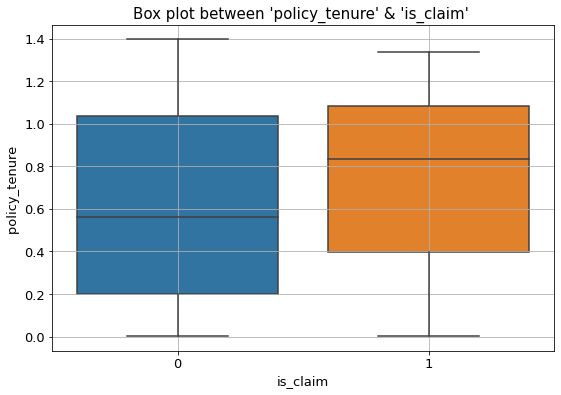

time: 172 ms (started: 2022-11-23 16:28:09 +00:00)


In [34]:
plt.figure(figsize=(9, 6))
ax = sns.boxplot(x = 'is_claim', y = 'policy_tenure', data = df)

#plt.legend(fontsize = 13)

# y-axis
plt.ylabel("policy_tenure ", fontdict = {'fontsize': 13})
plt.yticks(size=13)

#x-axis
plt.xlabel("is_claim", fontdict = {'fontsize': 13})
plt.xticks(size=13)

# title
plt.title("Box plot between 'policy_tenure' & 'is_claim' ", fontdict = {'fontsize': 15})

#plotting the graph
plt.grid()
plt.show()

## Observations:
1. Customers who has claimed the insurance are having more policty tenure when compared to the ones who didnot claim.
2. Nearly 50% of the customers who has claimed the insurance are having policy tenure = 0.8 which is only 0.55 for customers who has not claimed.

## Box plot between 'age_of_car' & 'is_claim'

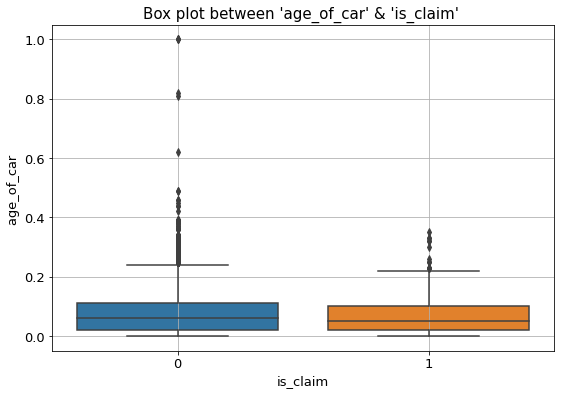

time: 157 ms (started: 2022-11-23 16:28:09 +00:00)


In [35]:
plt.figure(figsize=(9, 6))

# specifying x and y axis for our graph
ax = sns.boxplot(x = 'is_claim', y = 'age_of_car', data = df);

#plt.legend(fontsize = 13)

# y-axis
plt.ylabel("age_of_car ", fontdict = {'fontsize': 13})
plt.yticks(size=13)

# x-axis
plt.xlabel("is_claim", fontdict = {'fontsize': 13})
plt.xticks(size=13)

# title
plt.title("Box plot between 'age_of_car' & 'is_claim' ", fontdict = {'fontsize': 15})

# plotting the graph
plt.grid()
plt.show()

## Observations:
1. age of the cars is very much high for the customers who has not claimed. 

## Box plot betwen 'age_of_policyholder' & 'is_claim' 

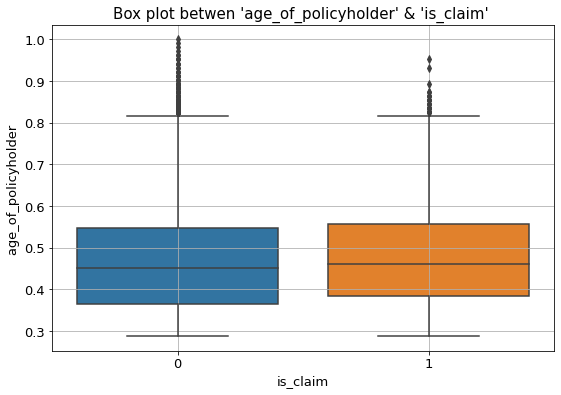

time: 195 ms (started: 2022-11-23 16:28:09 +00:00)


In [36]:
plt.figure(figsize=(9, 6))

# specifying x and y axis for our graph
ax = sns.boxplot(x = 'is_claim', y = 'age_of_policyholder', data = df)

#plt.legend(fontsize = 13)

# y-axis
plt.ylabel("age_of_policyholder ", fontdict = {'fontsize': 13})
plt.yticks(size=13)

# x-axis
plt.xlabel("is_claim", fontdict = {'fontsize': 13})
plt.xticks(size=13)

# title
plt.title("Box plot betwen 'age_of_policyholder' & 'is_claim' ", fontdict = {'fontsize': 15})

# plotting the graph
plt.grid()
plt.show()

## Observations:
1. Age of policy holders who not claimed is little high when compared to the customers who has claimed.

## Density of claims in different Area Clusters

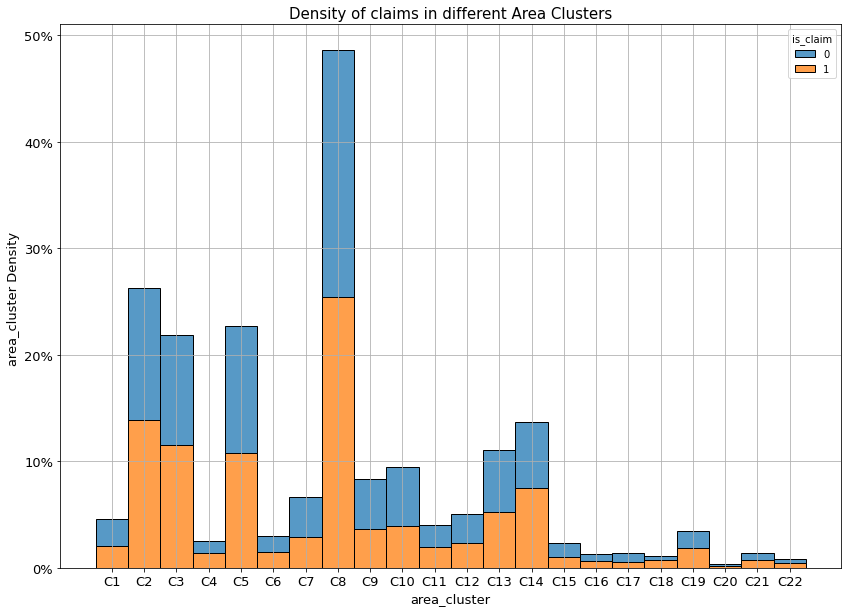

time: 429 ms (started: 2022-11-23 16:28:09 +00:00)


In [37]:
plt.figure(figsize=(14, 10))

# specifying x and y axis for our graph
ax = sns.histplot(x = 'area_cluster', hue = 'is_claim', data = df, multiple = 'stack', stat = 'density', common_norm = False); 

# y-axis
plt.ylabel("area_cluster Density ", fontdict = {'fontsize': 13})
plt.yticks(size=13)

# x-axis
plt.xlabel("area_cluster", fontdict = {'fontsize': 13})
plt.xticks(size=13)

# title
plt.title("Density of claims in different Area Clusters", fontdict = {'fontsize': 15})
from matplotlib.ticker import PercentFormatter
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

# plotting the graph
plt.grid()
plt.show()

## Observation: 
1. We can observer that most of the policy holders are the area_cluster C8 and least are from C20 area cluster.

## Box plot between 'is_claim' and 'population_density'

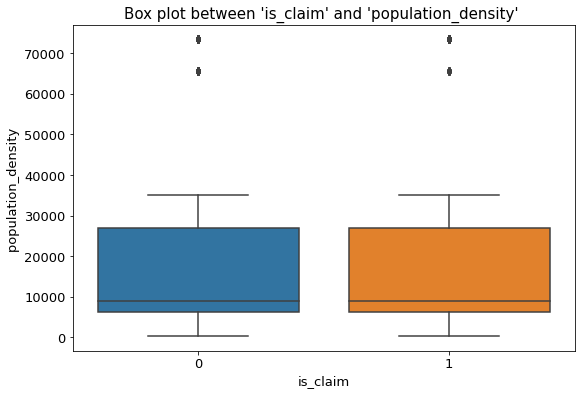

time: 165 ms (started: 2022-11-23 16:28:10 +00:00)


In [38]:
plt.figure(figsize=(9, 6))

# specifying x and y axis for our graph
ax = sns.boxplot(x = 'is_claim', y = 'population_density', data = df); 

# y-axis
plt.ylabel("population_density ", fontdict = {'fontsize': 13})
plt.yticks(size=13)

# x-axis
plt.xlabel("is_claim", fontdict = {'fontsize': 13})
plt.xticks(size=13)

# title
plt.title("Box plot between 'is_claim' and 'population_density' ", fontdict = {'fontsize': 15})

# plotting the graph
plt.show()

## Observation: 
1. population density is almost same in both the categories.

In [39]:
df.make.value_counts().sort_values(ascending = False)
                                  

1    38126
3    14018
2     2373
5     2114
4     1961
Name: make, dtype: int64

time: 9.51 ms (started: 2022-11-23 16:28:10 +00:00)


## Plot between 'is_claim' density based on 'make'

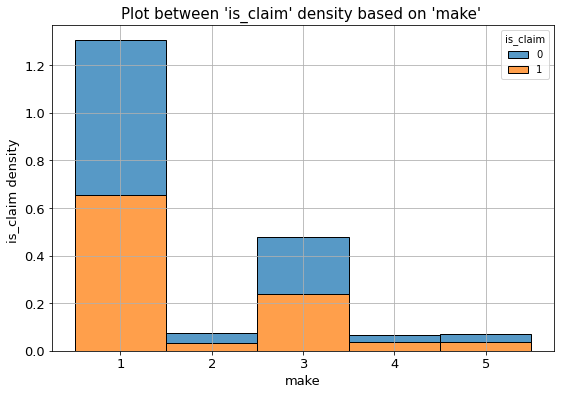

time: 422 ms (started: 2022-11-23 16:28:10 +00:00)


In [40]:
df['make'] = df['make'].astype('category')

plt.figure(figsize=(9, 6))

# specifying x and y axis for our graph
ax = sns.histplot(x = 'make', hue = 'is_claim', data = df, multiple = 'stack', stat = 'density', common_norm=False); 

# y-axis
plt.ylabel("is_claim density ", fontdict = {'fontsize': 13})
plt.yticks(size=13)

# x-axis
plt.xlabel("make", fontdict = {'fontsize': 13})
plt.xticks(size=13)

# title
plt.title("Plot between 'is_claim' density based on 'make' ", fontdict = {'fontsize': 15})

# plotting the graph
plt.grid()
plt.show()

## Observation: 
1. We can observe that most of the policy holders are from make = 1 cateogory and claimed, not claimed ration is alomost same in the same type.

## Plot between 'is_claim' density based on 'segment' 

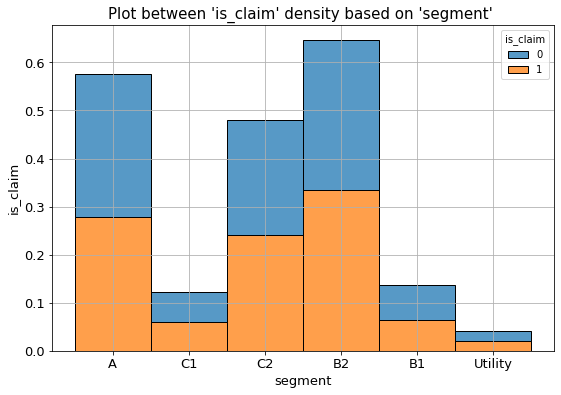

time: 273 ms (started: 2022-11-23 16:28:10 +00:00)


In [41]:
plt.figure(figsize=(9, 6))

# specifying x and y axis for our graph
ax = sns.histplot(x = 'segment', hue = 'is_claim', data = df, multiple = 'stack', stat = 'density', common_norm=False) ; 

# y-axis
plt.ylabel("is_claim", fontdict = {'fontsize': 13})
plt.yticks(size=13)

# x-axis
plt.xlabel("segment", fontdict = {'fontsize': 13})
plt.xticks(size=13)

# title
plt.title("Plot between 'is_claim' density based on 'segment' ", fontdict = {'fontsize': 15})

# plotting the graph
plt.grid()
plt.show()

## Plot between 'is_claim' density based on 'model' of the Car

In [42]:
a = df.groupby(['is_claim']).model.value_counts(normalize = False)
print(a)

is_claim  model
0         M1       14030
          M4       13117
          M6       12837
          M8        3929
          M7        2739
          M3        2245
          M9        1981
          M5        1482
          M10       1136
          M2        1000
          M11        348
1         M6         939
          M1         918
          M4         901
          M8         244
          M7         201
          M9         133
          M3         128
          M5         116
          M2          80
          M10         73
          M11         15
Name: model, dtype: int64
time: 19.2 ms (started: 2022-11-23 16:28:10 +00:00)


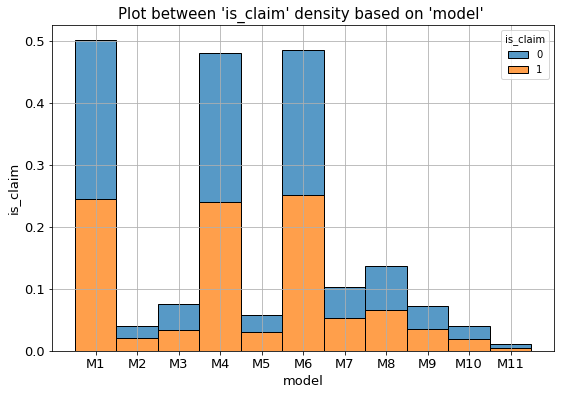

time: 315 ms (started: 2022-11-23 16:28:10 +00:00)


In [43]:
plt.figure(figsize=(9, 6))

# specifying x and y axis for our graph
ax = sns.histplot(x = 'model', hue = 'is_claim', data = df, multiple = 'stack', stat = 'density', common_norm=False); 

# y-axis
plt.ylabel("is_claim", fontdict = {'fontsize': 13})
plt.yticks(size=13)

# x-axis
plt.xlabel("model", fontdict = {'fontsize': 13})
plt.xticks(size=13)

# title
plt.title("Plot between 'is_claim' density based on 'model' ", fontdict = {'fontsize': 15})

# plotting the graph
plt.grid()
plt.show()

## Observations:
1. We can observe that most of the claims are done by the model M6 which is around  939 and least number of claims i.e, 15 are made by M11 model.


## Plot between 'is_claim' density based on 'fuel_type'

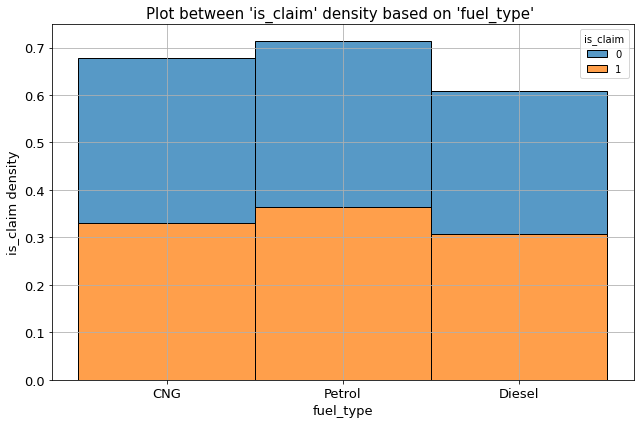

time: 317 ms (started: 2022-11-23 16:28:11 +00:00)


In [44]:
plt.figure(figsize=(9, 6))

# specifying x and y axis for our graph
ax = sns.histplot(x = 'fuel_type', hue = 'is_claim', data = df, multiple = 'stack', stat = 'density', common_norm=False); 

# y-axis
plt.ylabel("is_claim density", fontdict = {'fontsize': 13})
plt.yticks(size=13)

# x-axis
plt.xlabel("fuel_type", fontdict = {'fontsize': 13})
plt.xticks(size=13)

# title
plt.title("Plot between 'is_claim' density based on 'fuel_type' ", fontdict = {'fontsize': 15})

# plotting the graph
plt.grid()
plt.tight_layout()
plt.show()

## Observation: 
1. Most of the Claims are made by the cars which are having fuel_type as Petrol and next to this almost equal number of claims are made by the cars which are having fuel type of Diesel and CNG.

In [45]:
a = df.groupby(['is_claim']).max_torque.value_counts(normalize = True)
print(a)

is_claim  max_torque    
0         113Nm@4400rpm     0.302239
          60Nm@3500rpm      0.255816
          250Nm@2750rpm     0.239169
          82.1Nm@3400rpm    0.071640
          91Nm@4250rpm      0.040934
          200Nm@1750rpm     0.036121
          200Nm@3000rpm     0.027022
          85Nm@3000rpm      0.020713
          170Nm@4000rpm     0.006345
1         113Nm@4400rpm     0.325507
          60Nm@3500rpm      0.244931
          250Nm@2750rpm     0.240395
          82.1Nm@3400rpm    0.065101
          200Nm@1750rpm     0.035486
          91Nm@4250rpm      0.034152
          200Nm@3000rpm     0.030950
          85Nm@3000rpm      0.019477
          170Nm@4000rpm     0.004002
Name: max_torque, dtype: float64
time: 19.7 ms (started: 2022-11-23 16:28:11 +00:00)


## Plot between 'is_claim' density based on 'max_torque' 

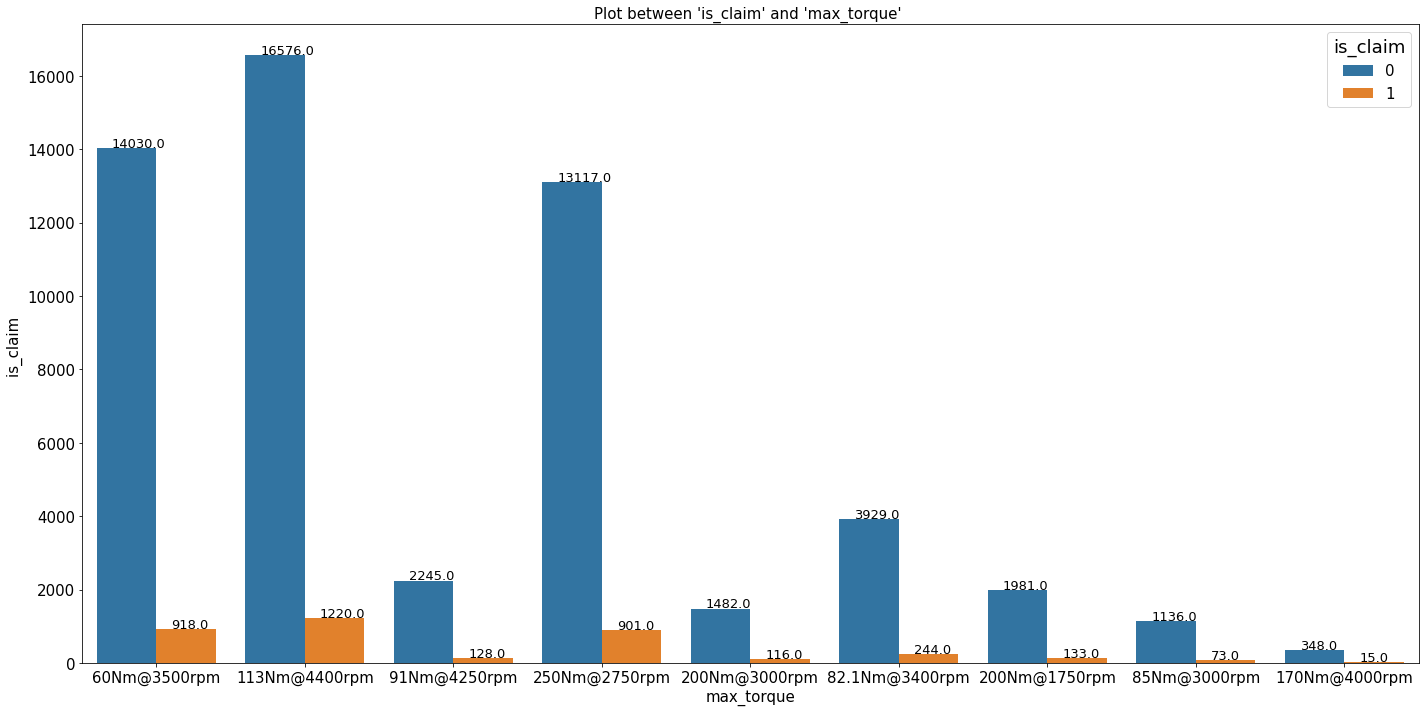

time: 508 ms (started: 2022-11-23 16:28:11 +00:00)


In [46]:
plt.figure(figsize=(20, 10))
ax = sns.countplot(data = df, x='max_torque', hue='is_claim')

# adding legend with title
plt.legend(title = 'is_claim', title_fontsize = 18, fontsize = 15)

# x-axis
plt.xlabel("max_torque", fontdict = {'fontsize': 15})
plt.xticks(size = 15)

# y-axis
plt.ylabel("is_claim ", fontdict = {'fontsize': 15})
plt.yticks(size = 15)

# adding title
plt.title("Plot between 'is_claim' and 'max_torque' ", fontdict = {'fontsize': 15})

# annotating the bars
for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+25), ha='left', va='baseline', fontsize = 13)

# plotting the graph
#plt.grid()
plt.tight_layout()        
plt.show()

## Observation:
1. 1220 claims are made by the cars which are having max_torque as 113Nm@440rpm and least of them which is 15 claims were made by cars having max_torque as 170Nm@4000 rpm.

## Plot between 'is_claim' and 'max_power'

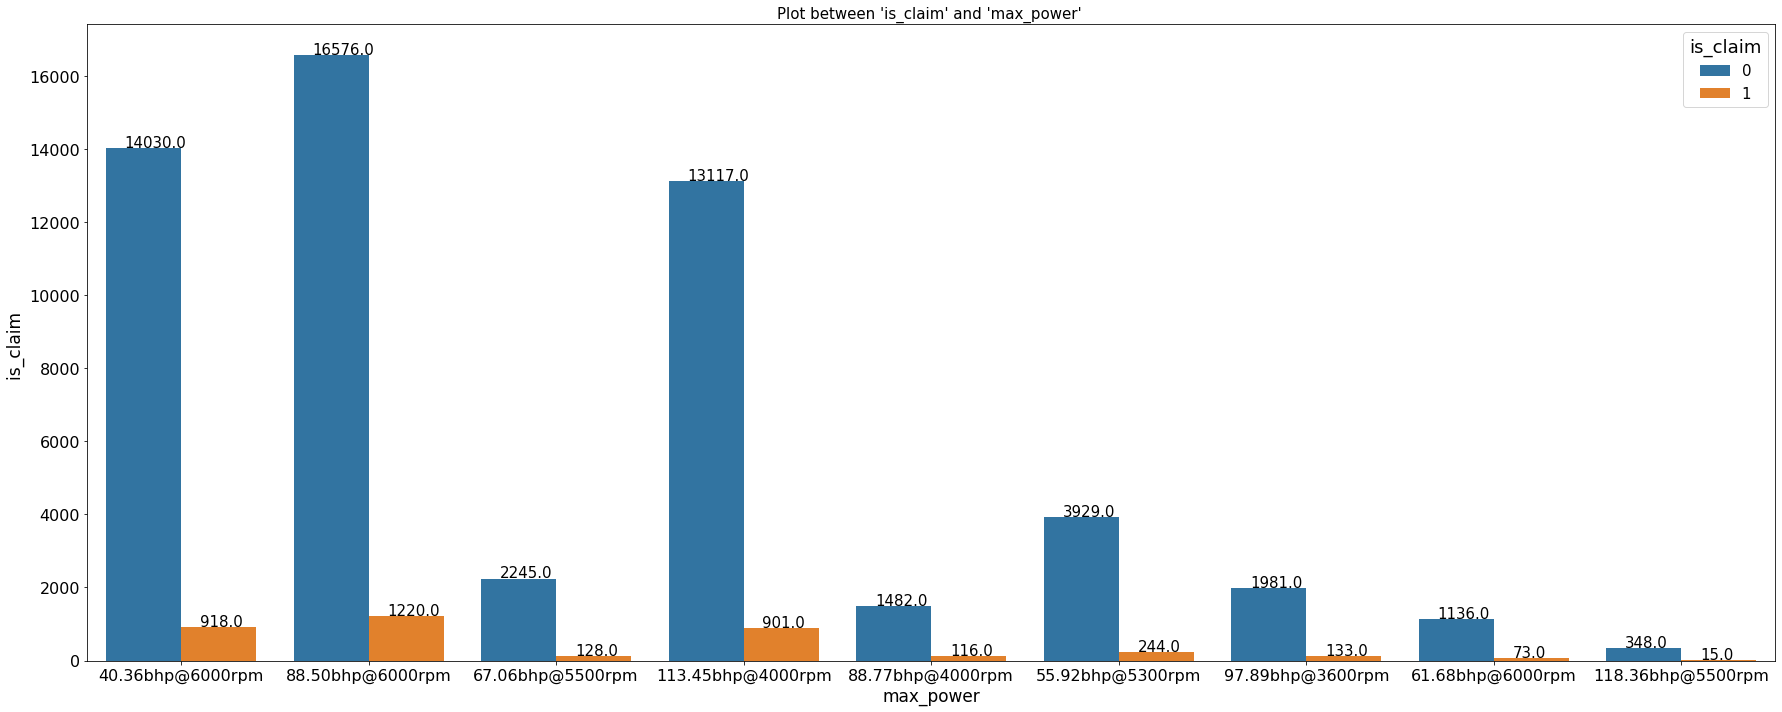

In [47]:
plt.figure(figsize=(25, 10))
ax = sns.countplot(data = df, x='max_power', hue='is_claim')

# adding legend with title
plt.legend(title = 'is_claim', title_fontsize = 18, fontsize = 15)

# x-axis
plt.xlabel("max_power", fontdict = {'fontsize': 17})
plt.xticks(size = 16)

# y-axis
plt.ylabel("is_claim ", fontdict = {'fontsize': 17})
plt.yticks(size = 16)

# adding title
plt.title("Plot between 'is_claim' and 'max_power' ", fontdict = {'fontsize': 15})

# annotating the bars
for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+25), ha='left', va='baseline', fontsize = 15)

# plotting the graph
#plt.grid()
plt.tight_layout()        
plt.show()

## Observation: 
1. We can observe that the cars which are having max_power of 88.50bhp@6000rpm has made as highest of 1220 claims and least numbers of claims are made by the cars that have max_power of 118.36bhp@5500rpm which is 15 claims.

## Plot between 'is_claim' and 'engine_type'

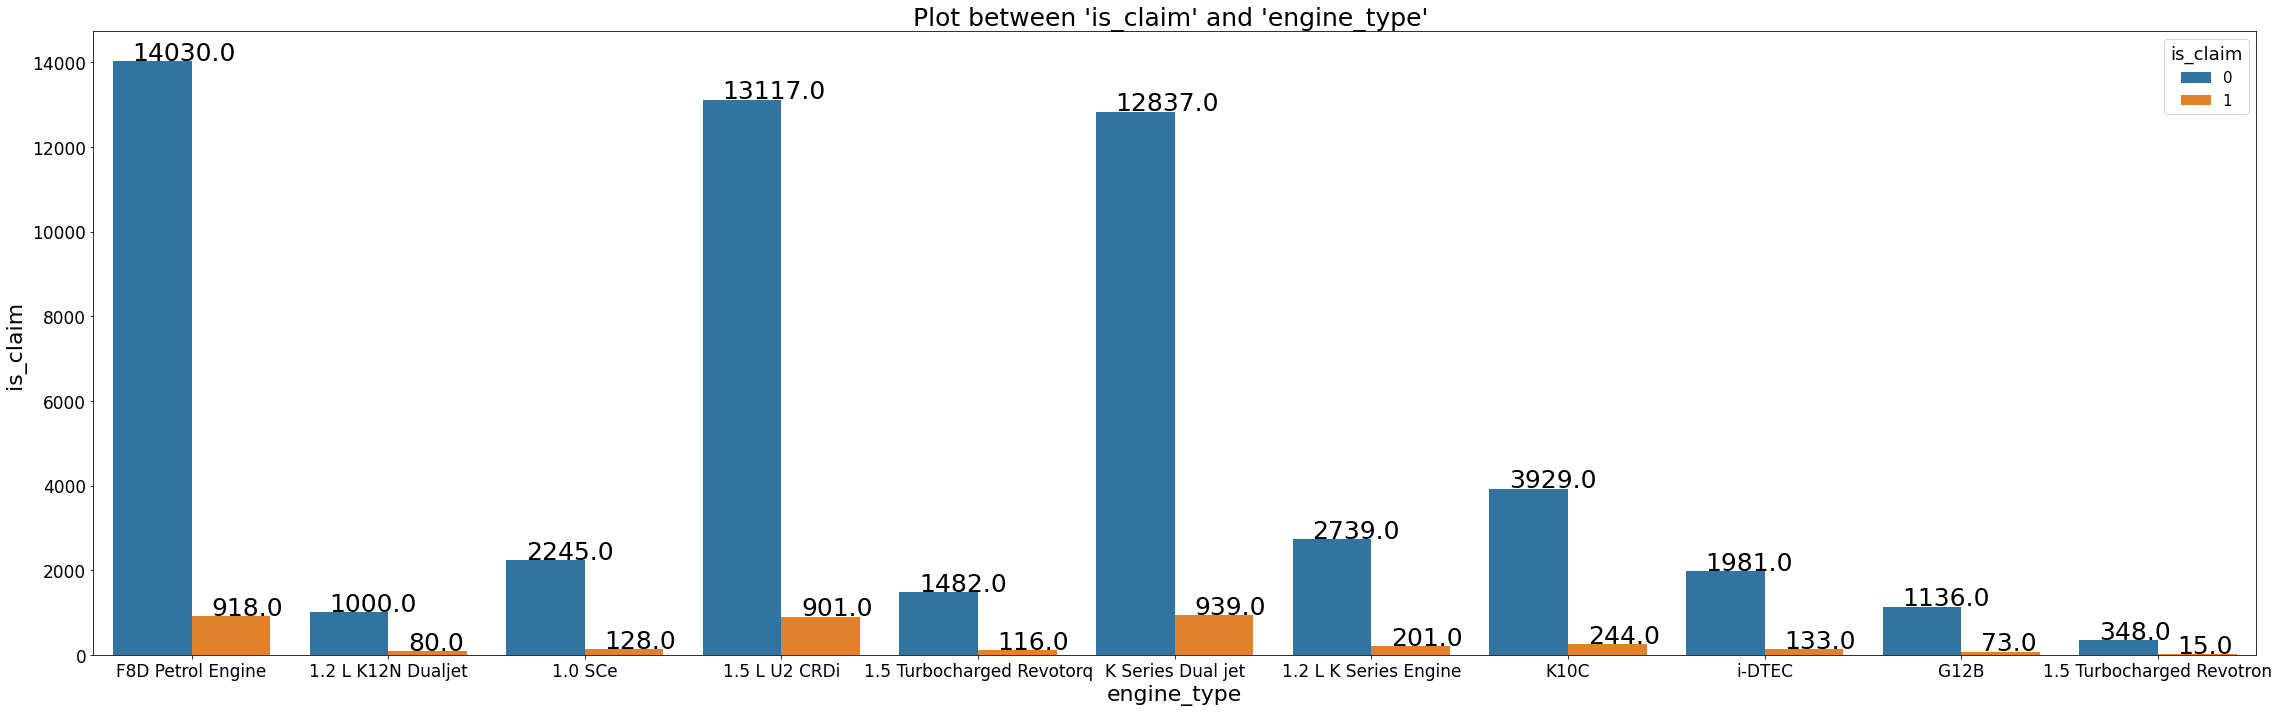

time: 1.21 s (started: 2022-11-23 16:29:32 +00:00)


In [51]:
plt.figure(figsize=(32, 10))
ax = sns.countplot(data = df, x='engine_type', hue='is_claim')

# adding legend with title
plt.legend(title = 'is_claim', title_fontsize = 18, fontsize = 15)

# x-axis
plt.xlabel("engine_type", fontdict = {'fontsize': 22})
plt.xticks(size = 17)

# y-axis
plt.ylabel("is_claim ", fontdict = {'fontsize': 22})
plt.yticks(size = 17)

# adding title
plt.title("Plot between 'is_claim' and 'engine_type' ", fontdict = {'fontsize': 25})

# annotating the bars
for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+25), ha='left', va='baseline', fontsize = 25)

# plotting the graph
# plt.grid()
plt.tight_layout()        
plt.show()

## Observation:
1. Most number of claims are made by the cars that have engine type as F&D Petrol engine and least number by the ones which have engine type as 1.5 Turbocharged Revotron

## Plot between 'is_claim' and 'airbags'

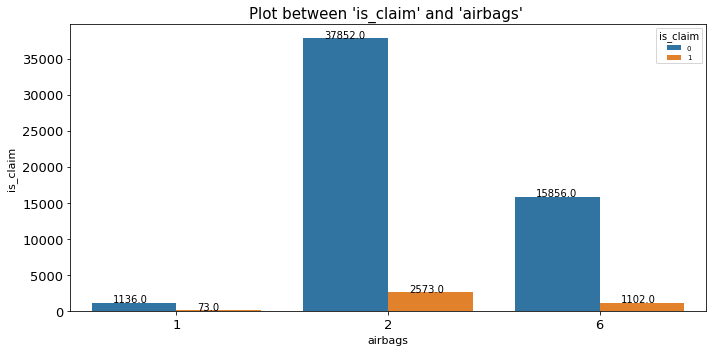

time: 264 ms (started: 2022-11-23 16:28:13 +00:00)


In [49]:
plt.figure(figsize=(10, 5))
ax = sns.countplot(data = df, x='airbags', hue='is_claim')

# adding legend with title
plt.legend(title = 'is_claim', title_fontsize = 10, fontsize = 7)

# x-axis
plt.xlabel("airbags", fontdict = {'fontsize': 11})
plt.xticks(size = 13)

# y-axis
plt.ylabel("is_claim ", fontdict = {'fontsize': 11})
plt.yticks(size = 13)

# adding title
plt.title("Plot between 'is_claim' and 'airbags' ", fontdict = {'fontsize': 15})

# annotating the bars
for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+25), ha='left', va='baseline', fontsize = 10)

# plotting the graph
#plt.grid()
plt.tight_layout()        
plt.show()

## Observations:
1. Cars that have only 2 air bags have claimed more times when compared to the ones have 1 and 6 air bags .

In [104]:
cols = ['is_esc', 'is_adjustable_steering', 'is_tpms', 'is_parking_sensors', 'is_parking_camera',
        'is_front_fog_lights', 'is_rear_window_wiper', 'is_rear_window_washer',
        'is_rear_window_defogger', 'is_brake_assist', 'is_power_door_locks', 'is_central_locking', 'is_power_steering',
        'is_driver_seat_height_adjustable', 'is_day_night_rear_view_mirror', 'is_ecw', 'is_speed_alert']

for col in cols:
    df[col] = np.where(df[col] == 'Yes', 1, 0)
    
for col in cols:
    oot[col] = np.where(oot[col] == 'Yes', 1, 0)

time: 357 ms (started: 2022-11-23 16:45:20 +00:00)


# Modelling - LGBM
---

## Train and Validation Split

In [105]:
X = df.drop(columns = ['policy_id', 'is_claim'])
y = df['is_claim']

time: 22.9 ms (started: 2022-11-23 16:45:26 +00:00)


In [106]:
# using 10% of the given data in testing
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, stratify = y, random_state = 1)


time: 44.6 ms (started: 2022-11-23 16:45:28 +00:00)


In [107]:
print("Number of points available in Training data for each claim type are:")
y_train.value_counts()

Number of points available in Training data for each claim type are:


0    49359
1     3373
Name: is_claim, dtype: int64

time: 8.87 ms (started: 2022-11-23 16:45:31 +00:00)


In [108]:
val = (y_train.value_counts(normalize = True)) * 100
print("Percentage of points available in Training data for each claim type are:")
print(val)
# we can observe that nearly 93% percent of the values are having is_claim status as '0' and other 6% have as status '1'

Percentage of points available in Training data for each claim type are:
0    93.603505
1     6.396495
Name: is_claim, dtype: float64
time: 3.89 ms (started: 2022-11-23 16:45:33 +00:00)


In [109]:
print("Number of points available in Test data for each claim type are:")
y_test.value_counts()

Number of points available in Test data for each claim type are:


0    5485
1     375
Name: is_claim, dtype: int64

time: 8.43 ms (started: 2022-11-23 16:45:37 +00:00)


In [110]:
val = (y_test.value_counts(normalize = True)) * 100
print("Percentage of points available in Test data for each claim type are:")
print(val)


Percentage of points available in Test data for each claim type are:
0    93.600683
1     6.399317
Name: is_claim, dtype: float64
time: 5.68 ms (started: 2022-11-23 16:45:39 +00:00)


## References for WOEEncoder( Weight of Evidence): 
1. https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html
2. https://towardsdatascience.com/an-easier-way-to-encode-categorical-features-d840ff6b3900
3. https://www.analyticsvidhya.com/blog/2021/06/understand-weight-of-evidence-and-information-value/


In [111]:
# implementing Weight of Evidence Encoding
woe = WOEEncoder()

time: 723 µs (started: 2022-11-23 16:45:44 +00:00)


In [112]:
# listing down all the categorical features in our Data
feature_list = ['area_cluster', 'make', 'segment', 'model', 'fuel_type', 'max_torque', 'max_power', 'engine_type',
                 'rear_brakes_type', 'transmission_type', 'steering_type']

time: 976 µs (started: 2022-11-23 16:45:46 +00:00)


In [113]:
# applying WOEEncoder on Train and Test data sets
train_woe = woe.fit_transform(x_train[feature_list], y_train)
test_woe = woe.transform(x_test[feature_list])
oot_woe = woe.transform(oot[feature_list])

time: 1.01 s (started: 2022-11-23 16:45:48 +00:00)


In [114]:
train_woe.shape


(52732, 11)

time: 3.89 ms (started: 2022-11-23 16:45:54 +00:00)


In [115]:
train_woe.head()

,area_cluster,make,segment,model,fuel_type,max_torque,max_power,engine_type,rear_brakes_type,transmission_type,steering_type
42769,0.104014,1,0.090258,0.076777,0.043882,0.083521,0.083521,0.076777,0.002479,0.003574,0.054712
35051,0.104014,1,-0.060953,-0.037514,-0.053764,-0.037514,-0.037514,-0.037514,0.002479,0.003574,-0.040718
12127,0.116440,1,-0.060953,-0.037514,-0.053764,-0.037514,-0.037514,-0.037514,0.002479,0.003574,-0.040718
17456,0.127955,1,0.090258,0.076777,0.043882,0.083521,0.083521,0.076777,0.002479,0.003574,0.054712
17734,-0.087772,3,-0.007887,-0.007887,0.009051,-0.007887,-0.007887,-0.007887,-0.007887,-0.006683,-0.040718


time: 18.2 ms (started: 2022-11-23 16:45:55 +00:00)


In [116]:
x_train.drop(columns = feature_list, inplace = True)
x_test.drop(columns = feature_list, inplace = True)
oot.drop(columns = feature_list, inplace = True)

time: 19.5 ms (started: 2022-11-23 16:46:01 +00:00)


In [117]:
x_train_final = pd.concat([x_train, train_woe], axis = 1)
x_test_final = pd.concat([x_test, test_woe], axis = 1)
oot_final = pd.concat([oot, oot_woe], axis = 1)

time: 21.2 ms (started: 2022-11-23 16:46:07 +00:00)


In [118]:
x_train_final.head()


,policy_tenure,age_of_car,age_of_policyholder,population_density,airbags,is_esc,is_adjustable_steering,is_tpms,is_parking_sensors,is_parking_camera,displacement,cylinder,gear_box,turning_radius,length,width,height,gross_weight,is_front_fog_lights,is_rear_window_wiper,is_rear_window_washer,is_rear_window_defogger,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,area_cluster,make,segment,model,fuel_type,max_torque,max_power,engine_type,rear_brakes_type,transmission_type,steering_type
42769,0.868744,0.08,0.346154,8794,2,0,1,0,1,0,1197,4,5,4.8,3845,1735,1530,1335,1,0,0,0,1,1,1,1,1,1,1,1,2,0.104014,1,0.090258,0.076777,0.043882,0.083521,0.083521,0.076777,0.002479,0.003574,0.054712
35051,0.383458,0.00,0.509615,8794,2,0,0,0,1,0,796,3,5,4.6,3445,1515,1475,1185,0,0,0,0,0,0,0,1,0,0,0,1,0,0.104014,1,-0.060953,-0.037514,-0.053764,-0.037514,-0.037514,-0.037514,0.002479,0.003574,-0.040718
12127,0.869126,0.00,0.423077,4076,2,0,0,0,1,0,796,3,5,4.6,3445,1515,1475,1185,0,0,0,0,0,0,0,1,0,0,0,1,0,0.116440,1,-0.060953,-0.037514,-0.053764,-0.037514,-0.037514,-0.037514,0.002479,0.003574,-0.040718
17456,0.766596,0.01,0.307692,27742,2,0,1,0,1,0,1197,4,5,4.8,3845,1735,1530,1335,1,0,0,0,1,1,1,1,1,1,1,1,2,0.127955,1,0.090258,0.076777,0.043882,0.083521,0.083521,0.076777,0.002479,0.003574,0.054712
17734,0.031597,0.06,0.298077,5410,6,1,1,1,1,1,1493,4,6,5.2,4300,1790,1635,1720,1,1,1,1,1,1,1,1,1,0,1,1,3,-0.087772,3,-0.007887,-0.007887,0.009051,-0.007887,-0.007887,-0.007887,-0.007887,-0.006683,-0.040718


time: 31 ms (started: 2022-11-23 16:46:07 +00:00)


In [119]:
x_test_final.head()

,policy_tenure,age_of_car,age_of_policyholder,population_density,airbags,is_esc,is_adjustable_steering,is_tpms,is_parking_sensors,is_parking_camera,displacement,cylinder,gear_box,turning_radius,length,width,height,gross_weight,is_front_fog_lights,is_rear_window_wiper,is_rear_window_washer,is_rear_window_defogger,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,area_cluster,make,segment,model,fuel_type,max_torque,max_power,engine_type,rear_brakes_type,transmission_type,steering_type
24307,0.867852,0.02,0.653846,4076,2,0,0,0,1,0,796,3,5,4.6,3445,1515,1475,1185,0,0,0,0,0,0,0,1,0,0,0,1,0,0.116440,1,-0.060953,-0.037514,-0.053764,-0.037514,-0.037514,-0.037514,0.002479,0.003574,-0.040718
57327,1.090563,0.17,0.451923,8794,2,0,1,0,1,1,1498,4,5,4.9,3995,1695,1501,1051,1,0,0,1,0,1,1,1,1,1,1,1,4,0.104014,5,-0.010470,-0.029199,0.009051,-0.029199,-0.029199,-0.029199,0.002479,0.003574,0.054712
24703,1.088634,0.18,0.423077,8794,2,0,1,0,1,0,1197,4,5,4.8,3845,1735,1530,1335,1,0,0,0,1,1,1,1,1,1,1,1,2,0.104014,1,0.090258,0.076777,0.043882,0.083521,0.083521,0.076777,0.002479,0.003574,0.054712
40585,0.913375,0.01,0.605769,4076,6,1,1,1,1,1,1493,4,6,5.2,4300,1790,1635,1720,1,1,1,1,1,1,1,1,1,0,1,1,3,0.116440,3,-0.007887,-0.007887,0.009051,-0.007887,-0.007887,-0.007887,-0.007887,-0.006683,-0.040718
17527,0.745566,0.04,0.576923,6108,2,0,0,0,1,0,796,3,5,4.6,3445,1515,1475,1185,0,0,0,0,0,0,0,1,0,0,0,1,0,-0.105572,1,-0.060953,-0.037514,-0.053764,-0.037514,-0.037514,-0.037514,0.002479,0.003574,-0.040718


time: 32.1 ms (started: 2022-11-23 16:46:18 +00:00)


In [120]:
oot_final.head()


,policy_id,policy_tenure,age_of_car,age_of_policyholder,population_density,airbags,is_esc,is_adjustable_steering,is_tpms,is_parking_sensors,is_parking_camera,displacement,cylinder,gear_box,turning_radius,length,width,height,gross_weight,is_front_fog_lights,is_rear_window_wiper,is_rear_window_washer,is_rear_window_defogger,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,area_cluster,make,segment,model,fuel_type,max_torque,max_power,engine_type,rear_brakes_type,transmission_type,steering_type
0,ID58593,0.341732,0.00,0.586538,4076,2,0,0,0,1,0,796,3,5,4.6,3445,1515,1475,1185,0,0,0,0,0,0,0,1,0,0,0,1,0,0.116440,1,-0.060953,-0.037514,-0.053764,-0.037514,-0.037514,-0.037514,0.002479,0.003574,-0.040718
1,ID58594,0.307241,0.13,0.442308,8794,2,0,1,0,1,0,1197,4,5,4.8,3845,1735,1530,1335,1,0,0,0,1,1,1,1,1,1,1,1,2,0.104014,1,0.090258,0.076777,0.043882,0.083521,0.083521,0.076777,0.002479,0.003574,0.054712
2,ID58595,0.327924,0.12,0.451923,8794,2,0,0,0,0,1,999,3,5,5.0,3731,1579,1490,1155,0,0,0,0,0,1,1,1,0,1,1,1,2,0.104014,2,-0.060953,-0.212061,0.043882,-0.212061,-0.212061,-0.212061,0.002479,-0.006683,0.054712
3,ID58596,0.782654,0.01,0.461538,34738,2,0,0,0,1,0,796,3,5,4.6,3445,1515,1475,1185,0,0,0,0,0,0,0,1,0,0,0,1,0,-0.095075,1,-0.060953,-0.037514,-0.053764,-0.037514,-0.037514,-0.037514,0.002479,0.003574,-0.040718
4,ID58597,1.233404,0.02,0.634615,34738,2,0,0,0,1,0,796,3,5,4.6,3445,1515,1475,1185,0,0,0,0,0,0,0,1,0,0,0,1,0,-0.095075,1,-0.060953,-0.037514,-0.053764,-0.037514,-0.037514,-0.037514,0.002479,0.003574,-0.040718


time: 29 ms (started: 2022-11-23 16:46:23 +00:00)


## Hyperparameter tuning

In [121]:
# parameters that will be used for Random Seacrh CV
params  = {'num_leaves': [8, 12, 16, 20, 25],  
           'subsample': [0.5, 0.7, 0.9], 
           'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8],
           'reg_alpha': [0, 1e-1, 1, 5, 7, 10, 50],
           'reg_lambda': [0, 1e-1, 1, 5, 10, 50],
           'learning_rate': [0.015, 0.02, 0.03, 0.05, 0.07, 0.1, 0.2, 0.3],
           'n_estimators': [100, 120, 140, 150]}

time: 1.95 ms (started: 2022-11-23 16:46:28 +00:00)


In [122]:
lgbm = LGBMClassifier(objective = 'binary', is_unbalance = True, random_state = 1)


time: 1.04 ms (started: 2022-11-23 16:46:32 +00:00)


In [123]:
# performing Random Search on the above mentioned hyperparameters with 'f1' score as a metric
model_lgbm = RandomizedSearchCV(estimator = lgbm, 
                            param_distributions = params, 
                            n_iter = 30,
                            scoring ='f1', 
                            cv = 3, 
                            random_state = 1, 
                            verbose = 1)

model_lgbm.fit(x_train_final, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


RandomizedSearchCV(cv=3,
                   estimator=LGBMClassifier(is_unbalance=True,
                                            objective='binary',
                                            random_state=1),
                   n_iter=30,
                   param_distributions={'colsample_bytree': [0.4, 0.5, 0.6, 0.7,
                                                             0.8],
                                        'learning_rate': [0.015, 0.02, 0.03,
                                                          0.05, 0.07, 0.1, 0.2,
                                                          0.3],
                                        'n_estimators': [100, 120, 140, 150],
                                        'num_leaves': [8, 12, 16, 20, 25],
                                        'reg_alpha': [0, 0.1, 1, 5, 7, 10, 50],
                                        'reg_lambda': [0, 0.1, 1, 5, 10, 50],
                                        'subsample': [0.5, 0.7, 0.9]},
      

time: 1min 14s (started: 2022-11-23 16:46:32 +00:00)


In [124]:
# best score using our LGBM Model
model_lgbm.best_score_

0.1696347022813929

time: 4.18 ms (started: 2022-11-23 16:48:12 +00:00)


In [125]:
# best Parameteres for our LGBM Model
model_lgbm.best_params_

{'subsample': 0.9,
 'reg_lambda': 0,
 'reg_alpha': 0.1,
 'num_leaves': 8,
 'n_estimators': 140,
 'learning_rate': 0.015,
 'colsample_bytree': 0.5}

time: 3.81 ms (started: 2022-11-23 16:48:15 +00:00)


In [126]:
# defining LGBM Model based on Best parameters
lgbm_best = LGBMClassifier(objective = 'binary',
                           colsample_bytree = 0.5,
                           subsample = 0.9,
                           is_unbalance = True,
                           learning_rate = 0.015,
                           num_leaves = 8,
                           max_depth = 5,
                           reg_lambda = 0,
                           reg_alpha = 0.1,
                           n_estimators = 140,
                           random_state = 1)

time: 1.51 ms (started: 2022-11-23 16:48:38 +00:00)


In [127]:
# fitting on Train data
y_pred_train_lgbm = lgbm_best.fit(x_train_final, y_train)


time: 1.16 s (started: 2022-11-23 16:48:41 +00:00)


In [128]:
# predicting on the Test data
y_pred_test_lgbm = lgbm_best.predict(x_test_final)

time: 37.5 ms (started: 2022-11-23 16:48:48 +00:00)


In [173]:
''' function to evaluate our model using different metrics '''

# values to be passed :
# model_name = Our Model name, model = classifier used used to predict, y_train_pred, y_test_pred, x_train, x_test
def evaluate_model(model_name, model, y_train_pred, y_test_pred, x_train, x_test):

    print('Printing various Evaluation metrics for our '+str(model_name)+' model...........')
    print('\n')

    #***********************************************************************************************************#

    # Printing Train & Test Accuracy scores
    print("Train Accuracy :", accuracy_score(y_train, model.predict(x_train)))
    print("Test Accuracy :", accuracy_score(y_test, model.predict(x_test)))

    print('\n')
    print("="*60)
    print('\n')
   
    #***********************************************************************************************************#

    # Printing Confusion Matrix for Train & Test data
    print("Train Confusion Matrix:")
    print(confusion_matrix(y_train, model.predict(x_train)))
    print("Test Confusion Matrix:")
    print(confusion_matrix(y_test, model.predict(x_test)))

    print('\n')
    print("="*60)
    print('\n')

    #************************************************************************************************************#
    # Printing classification reports

    # For Train Data
    print("Classification report for our Model's Training data:")
    print("-"*52)
    print(classification_report(y_train, model.predict(x_train)))

    print('\n')
    print("="*60)
    print('\n')
    
    # For Train Data
    print("Classification report for our Model's Test data:")
    print("-"*52)
    print(classification_report(y_test, model.predict(x_test)))
  
    print('\n')
    print("="*60)
    print('\n')

    #**************************************************************************************************************#
    
    # Calculating AUC ROC scores
    auc_train_data = roc_auc_score(y_train, model.predict(x_train))
    auc_test_data = roc_auc_score(y_test, model.predict(x_test))
    print("AUC scores for \nTrain data is :", auc_train_data," & \nTest data is :", auc_test_data)
  
    print('\n')
    print("="*60)
    print('\n')

    # Plotting AUC ROC scores for Train & Test data
    # ROC Curve using predict_proba method 
    print("Plotting AUC ROC curves for Train and Test Data")
    tr_fpr, tr_tpr, tr_thresh = roc_curve(y_train, model.predict(x_train))
    te_fpr, te_tpr, te_thresh = roc_curve(y_test, model.predict(x_test))

    plt.style.use('seaborn')

    # plot roc curves
    plt.plot(tr_fpr, tr_tpr, linestyle='--', color='orange', label='Train AUC ='+str(auc(tr_fpr, tr_tpr).round(3)))
    plt.plot(te_fpr, te_tpr, linestyle='--', color='green', label='Test AUC ='+str(auc(te_fpr, te_tpr).round(3)))

    # title
    plt.title('ROC curve using '+str(model_name)+' model')
    # x label
    plt.xlabel('False Positive Rate')
    # y label
    plt.ylabel('True Positive rate')

    plt.legend(loc='best')

    plt.show();
    print('\n')
    
    #******************************************************************************************************************#

    # https://www.quantinsti.com/blog/creating-heatmap-using-python-seaborn

    # Plotting Train & Test Confusion matrices
    print("Plotting Train and Test Confusion matrices")
    sns.set()

    con_m_train = confusion_matrix(y_train, model.predict(x_train))
    con_m_test = confusion_matrix(y_test, model.predict(x_test))

    key = (np.asarray([['TN','FP'], ['FN', 'TP']]))
    fig, ax = plt.subplots(1,2, figsize=(12,5)) 

    labels_train = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(), con_m_train.flatten())])).reshape(2,2)
    labels_test = (np.asarray(["{0} = {1:.2f}" .format(key, value) for key, value in zip(key.flatten(), con_m_test.flatten())])).reshape(2,2)

    sns.heatmap(con_m_train, linewidths=.5, xticklabels=['PREDICTED : 0', 'PREDICTED : 1'], yticklabels=['ACTUAL : 0', 'ACTUAL : 1'], annot = labels_train, fmt = '', ax=ax[0], cmap='Blues')
    sns.heatmap(con_m_test, linewidths=.5, xticklabels=['PREDICTED : 0', 'PREDICTED : 1'], yticklabels=['ACTUAL : 0', 'ACTUAL : 1'], annot = labels_test, fmt = '', ax=ax[1], cmap='Blues')

    ax[0].set_title('Train Data')
    ax[1].set_title('Test Data')

    plt.show()
    print('\n')

    #*****************************************************************************************#

    # printing F1-score for Train and Test Datasets
    print('Printing F1-scores for our '+str(model_name)+' model')
    print("="*60)
    print('\n')

    # for Train Data
    f1_score_train = f1_score(y_train, model.predict(x_train))
    print('For Train data: \n ', f1_score_train ) 

    # for test data
    f1_score_test = f1_score(y_test, model.predict(x_test))
    print('For Test data: \n ', f1_score_test ) 
    print('\n')
   
    #*****************************************************************************************#



time: 44.3 ms (started: 2022-11-23 17:36:32 +00:00)


## Evaluation Metrics

Printing various Evaluation metrics for our LGBM model...........


Train Accuracy : 0.7122240764621103
Test Accuracy : 0.7136518771331058




Train Confusion Matrix:
[[35909 13450]
 [ 1725  1648]]
Test Confusion Matrix:
[[4000 1485]
 [ 193  182]]




Classification report for our Model's Training data:
----------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.73      0.83     49359
           1       0.11      0.49      0.18      3373

    accuracy                           0.71     52732
   macro avg       0.53      0.61      0.50     52732
weighted avg       0.90      0.71      0.78     52732





Classification report for our Model's Test data:
----------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.73      0.83      5485
           1       0.11      0.49      0.18       375

    accuracy                           0.71  

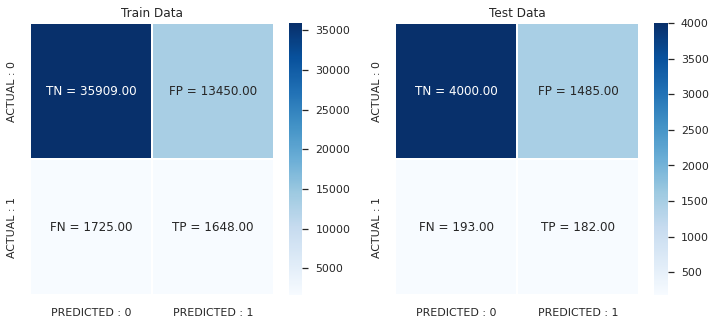



Printing F1-scores for our LGBM model


For Train data: 
  0.17844188186887555
For Test data: 
  0.178256611165524


time: 2.1 s (started: 2022-11-23 16:53:32 +00:00)


In [135]:
# function to evaluate our model using different metrics

# values to be passed :
# model_name = Our Model name, model = classifier used used to predict, y_train_pred, y_test_pred, x_train, x_test

model_name = 'LGBM'
evaluate_model(model_name, lgbm_best, y_pred_train_lgbm, y_pred_test_lgbm, x_train_final, x_test_final);

In [175]:
# storing f1 scores of Train and Test data in another variable to tabulate them at a larger stage
f1_Score_train_LGBM = 0.17844188186887555
f1_Score_test_LGBM = 0.178256611165524

time: 621 µs (started: 2022-11-23 17:37:24 +00:00)


In [200]:
print("F1-score of Train data using LGBM is : ", f1_Score_train_LGBM)
print("F1-score of Test data using LGBM is : ", f1_Score_test_LGBM)

F1-score of Train data using LGBM is :  0.17844188186887555
F1-score of Test data using LGBM is :  0.178256611165524
time: 1.66 ms (started: 2022-11-23 17:52:37 +00:00)


# Modelling - Catboost
---

In [143]:
# loading train data
df_train = pd.read_csv('train_qWM28Yl.csv')
df_train.head(2)


,policy_id,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,segment,model,fuel_type,max_torque,max_power,engine_type,airbags,is_esc,is_adjustable_steering,is_tpms,is_parking_sensors,is_parking_camera,rear_brakes_type,displacement,cylinder,transmission_type,gear_box,steering_type,turning_radius,length,width,height,gross_weight,is_front_fog_lights,is_rear_window_wiper,is_rear_window_washer,is_rear_window_defogger,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,is_claim
0,ID00001,0.515874,0.05,0.644231,C1,4990,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2,No,No,No,Yes,No,Drum,796,3,Manual,5,Power,4.6,3445,1515,1475,1185,No,No,No,No,No,No,No,Yes,No,No,No,Yes,0,0
1,ID00002,0.672619,0.02,0.375000,C2,27003,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2,No,No,No,Yes,No,Drum,796,3,Manual,5,Power,4.6,3445,1515,1475,1185,No,No,No,No,No,No,No,Yes,No,No,No,Yes,0,0


time: 332 ms (started: 2022-11-23 16:58:23 +00:00)


## References for Catboost classifier algorithm:
1. https://dataaspirant.com/catboost-algorithm/#t-1609567161984 
2. https://catboost.ai/en/docs/
3. https://stackoverflow.com/questions/59746304/catboost-classifier-for-class-imbalance

In [144]:
# we have a total of 58k observations in our Train data
df_train.shape

(58592, 44)

time: 7.54 ms (started: 2022-11-23 17:00:35 +00:00)


In [145]:
df_train.info()
# all the columns are not-null and this will help us a lot

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58592 entries, 0 to 58591
Data columns (total 44 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   policy_id                         58592 non-null  object 
 1   policy_tenure                     58592 non-null  float64
 2   age_of_car                        58592 non-null  float64
 3   age_of_policyholder               58592 non-null  float64
 4   area_cluster                      58592 non-null  object 
 5   population_density                58592 non-null  int64  
 6   make                              58592 non-null  int64  
 7   segment                           58592 non-null  object 
 8   model                             58592 non-null  object 
 9   fuel_type                         58592 non-null  object 
 10  max_torque                        58592 non-null  object 
 11  max_power                         58592 non-null  object 
 12  engi

In [146]:
df_train.describe()


,policy_tenure,age_of_car,age_of_policyholder,population_density,make,airbags,displacement,cylinder,gear_box,turning_radius,length,width,height,gross_weight,ncap_rating,is_claim
count,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.000000,58592.00000,58592.000000,58592.000000,58592.000000
mean,0.611246,0.069424,0.469420,18826.858667,1.763722,3.137066,1162.355851,3.626963,5.245443,4.852893,3850.476891,1672.233667,1553.33537,1385.276813,1.759950,0.063968
std,0.414156,0.056721,0.122886,17660.174792,1.136988,1.832641,266.304786,0.483616,0.430353,0.228061,311.457119,112.089135,79.62227,212.423085,1.389576,0.244698
min,0.002735,0.000000,0.288462,290.000000,1.000000,1.000000,796.000000,3.000000,5.000000,4.500000,3445.000000,1475.000000,1475.00000,1051.000000,0.000000,0.000000
25%,0.210250,0.020000,0.365385,6112.000000,1.000000,2.000000,796.000000,3.000000,5.000000,4.600000,3445.000000,1515.000000,1475.00000,1185.000000,0.000000,0.000000
50%,0.573792,0.060000,0.451923,8794.000000,1.000000,2.000000,1197.000000,4.000000,5.000000,4.800000,3845.000000,1735.000000,1530.00000,1335.000000,2.000000,0.000000
75%,1.039104,0.110000,0.548077,27003.000000,3.000000,6.000000,1493.000000,4.000000,5.000000,5.000000,3995.000000,1755.000000,1635.00000,1510.000000,3.000000,0.000000
max,1.396641,1.000000,1.000000,73430.000000,5.000000,6.000000,1498.000000,4.000000,6.000000,5.200000,4300.000000,1811.000000,1825.00000,1720.000000,5.000000,1.000000


time: 92 ms (started: 2022-11-23 17:00:43 +00:00)


In [202]:
# train.select_dtypes(include = ['int64']) This gives you a filtered dataframe where the dataframe is entirely NUMERIC dedicated.
# Similarly, when you perform train_df.dscribe(include = ['O']) it pulls out the objects dtypes attributes and shows their count/frequency/max/quartiles. 


time: 567 µs (started: 2022-11-23 17:59:57 +00:00)


In [147]:
df_train.describe(include=['O'])


,policy_id,area_cluster,segment,model,fuel_type,max_torque,max_power,engine_type,is_esc,is_adjustable_steering,is_tpms,is_parking_sensors,is_parking_camera,rear_brakes_type,transmission_type,steering_type,is_front_fog_lights,is_rear_window_wiper,is_rear_window_washer,is_rear_window_defogger,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert
count,58592,58592,58592,58592,58592,58592,58592,58592,58592,58592,58592,58592,58592,58592,58592,58592,58592,58592,58592,58592,58592,58592,58592,58592,58592,58592,58592,58592
unique,58592,22,6,11,3,9,9,11,2,2,2,2,2,2,2,3,2,2,2,2,2,2,2,2,2,2,2,2
top,ID00001,C8,B2,M1,Petrol,113Nm@4400rpm,88.50bhp@6000rpm,F8D Petrol Engine,No,Yes,No,Yes,No,Drum,Manual,Power,Yes,No,No,No,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes
freq,1,13654,18314,14948,20532,17796,17796,14948,40191,35526,44574,56219,35704,44574,38181,33502,33928,41634,41634,38077,32177,42435,42435,57383,34291,36309,42435,58229


time: 271 ms (started: 2022-11-23 17:00:47 +00:00)


In [148]:
# loading Test data
df_test = pd.read_csv('test_zo1G9sv.csv')
df_test.head(2)

,policy_id,policy_tenure,age_of_car,age_of_policyholder,area_cluster,population_density,make,segment,model,fuel_type,max_torque,max_power,engine_type,airbags,is_esc,is_adjustable_steering,is_tpms,is_parking_sensors,is_parking_camera,rear_brakes_type,displacement,cylinder,transmission_type,gear_box,steering_type,turning_radius,length,width,height,gross_weight,is_front_fog_lights,is_rear_window_wiper,is_rear_window_washer,is_rear_window_defogger,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating
0,ID58593,0.341732,0.00,0.586538,C3,4076,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2,No,No,No,Yes,No,Drum,796,3,Manual,5,Power,4.6,3445,1515,1475,1185,No,No,No,No,No,No,No,Yes,No,No,No,Yes,0
1,ID58594,0.307241,0.13,0.442308,C8,8794,1,B2,M6,Petrol,113Nm@4400rpm,88.50bhp@6000rpm,K Series Dual jet,2,No,Yes,No,Yes,No,Drum,1197,4,Manual,5,Electric,4.8,3845,1735,1530,1335,Yes,No,No,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2


time: 230 ms (started: 2022-11-23 17:00:55 +00:00)


In [149]:
df_test.shape
# we have a total of 39k observations in our Test data

(39063, 43)

time: 3.58 ms (started: 2022-11-23 17:00:55 +00:00)


In [150]:
# copying Train and Test data into new DataFrames
df_train_take = df_train.copy()
df_test_take = df_test.copy()

time: 20.5 ms (started: 2022-11-23 17:00:56 +00:00)


In [151]:
# removing policy id columns from the new DataFrames
df_train_take.drop(['policy_id'], axis = 1, inplace = True)
df_test_take.drop(['policy_id'], axis =1, inplace = True)

time: 30.5 ms (started: 2022-11-23 17:01:00 +00:00)


In [152]:
df_train['is_claim'].value_counts()
# this data is very much imbalanced

0    54844
1     3748
Name: is_claim, dtype: int64

time: 6.84 ms (started: 2022-11-23 17:01:00 +00:00)


In [153]:
df_train['is_claim'].value_counts( normalize = True)
# this data is very much imbalanced

0    0.936032
1    0.063968
Name: is_claim, dtype: float64

time: 9.63 ms (started: 2022-11-23 17:01:03 +00:00)


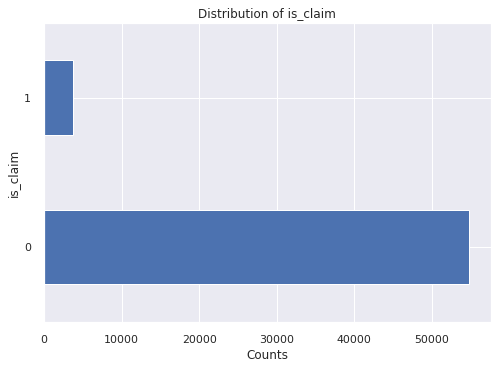

time: 319 ms (started: 2022-11-23 17:26:09 +00:00)


In [157]:
df_train['is_claim'].value_counts().plot(kind='barh')
plt.xlabel('Counts')
plt.ylabel('is_claim')
plt.title('Distribution of is_claim')
plt.show()

# from the plot we can clearly see that Data is imbalanced

In [158]:
df_train_take.shape

(58592, 43)

time: 4.13 ms (started: 2022-11-23 17:26:14 +00:00)


In [159]:
# dropping the column 'is_claim' from X and storing it in y
X = df_train_take.drop(['is_claim'], axis=1)
y = df_train_take['is_claim']
X_test = df_test_take.copy()

time: 27 ms (started: 2022-11-23 17:26:18 +00:00)


## Giving category as indexs to Catboost classifier

In [160]:
# storing all the categorical columns in a variable
categorical_features_indices = np.where((df_train_take.dtypes == object).values.astype(int) == 1)[0]


time: 2.76 ms (started: 2022-11-23 17:26:25 +00:00)


In [161]:
X.shape

(58592, 42)

time: 4.62 ms (started: 2022-11-23 17:26:26 +00:00)


In [168]:
# splitting data into train and validation with 30% of validation data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state = 42)


time: 43.9 ms (started: 2022-11-23 17:34:48 +00:00)


In [169]:
# shape of training and testing data sets
X_train.shape, X_val.shape

((41014, 42), (17578, 42))

time: 4.08 ms (started: 2022-11-23 17:34:54 +00:00)


In [167]:
# implementing Catboost with default parameters and scale_pos_weight = 10
catboost_base = CatBoostClassifier( random_state = 1, scale_pos_weight = 10, verbose = False)
catboost_base.fit(X_train, y_train, cat_features = categorical_features_indices, eval_set = (X_val, y_val))
print('\n')



time: 1min 54s (started: 2022-11-23 17:32:54 +00:00)


In [170]:
# predicting on the Train data
y_train_pred_CB = catboost_base.predict(X_train)

# predicting on the Validaiton data
y_test_pred_CB = catboost_base.predict(X_val)

# predicting on the actual given Test data
y_pred = catboost_base.predict(X_test)


time: 655 ms (started: 2022-11-23 17:35:07 +00:00)


## Evaluation Metrics

Printing various Evaluation metrics for our Catboost Classifier model...........


Train Accuracy : 0.823621202516214
Test Accuracy : 0.8152804642166345




Train Confusion Matrix:
[[32978  5449]
 [ 1785   802]]
Test Confusion Matrix:
[[13996  2421]
 [  826   335]]




Classification report for our Model's Training data:
----------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.86      0.90     38427
           1       0.13      0.31      0.18      2587

    accuracy                           0.82     41014
   macro avg       0.54      0.58      0.54     41014
weighted avg       0.90      0.82      0.86     41014





Classification report for our Model's Test data:
----------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.85      0.90     16417
           1       0.12      0.29      0.17      1161

    accuracy               

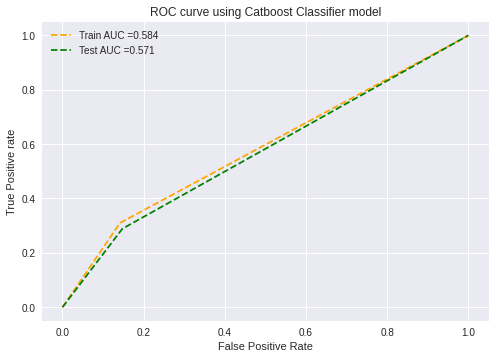



Plotting Train and Test Confusion matrices


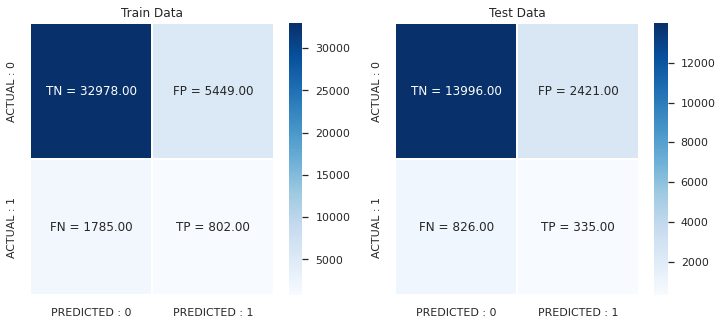



Printing F1-scores for our Catboost Classifier model


For Train data: 
  0.18148902466621408
For Test data: 
  0.17104927240234874


time: 3.92 s (started: 2022-11-23 17:36:39 +00:00)


In [174]:
# function to evaluate our model using different metrics

# values to be passed :
# model_name = Our Model name, model = classifier used used to predict, y_train_pred, y_test_pred, x_train, x_test

y_test = y_val
model_name = 'Catboost Classifier'
evaluate_model(model_name, catboost_base, y_train_pred_CB, y_test_pred_CB, X_train, X_val);

In [177]:
# storing f1 scores of Train and Test data in another variable to tabulate them at a larger stage
f1_Score_train_CB = 0.18148902466621408
f1_Score_test_CB = 0.17104927240234874

time: 10.3 ms (started: 2022-11-23 17:38:19 +00:00)


In [201]:
print("F1-score of Train data using Catboost Classifier is : ", f1_Score_train_CB)
print("F1-score of Test data using Catboost Classifier is : ", f1_Score_test_CB)

F1-score of Train data using Catboost Classifier is :  0.18148902466621408
F1-score of Test data using Catboost Classifier is :  0.17104927240234874
time: 3.09 ms (started: 2022-11-23 17:53:18 +00:00)


In [179]:
# predicting the given test data with our model
y_pred = catboost_base.predict(X_test)


time: 269 ms (started: 2022-11-23 17:38:46 +00:00)


In [180]:
# loading the sample submission file given to us
submission_df = pd.read_csv('sample_submission_KvRh9Sx.csv')
submission_df.head(2)

,policy_id,is_claim
0,ID58593,1
1,ID58594,1


time: 605 ms (started: 2022-11-23 17:38:50 +00:00)


In [181]:
# taking the 'policy_id' given in our test data to our submission DataFrame
submission_df['policy_id'] = df_test['policy_id']


time: 4.47 ms (started: 2022-11-23 17:38:54 +00:00)


In [182]:
# storing the predicted value in 'is_claim' column of our submission DataFrame
submission_df['is_claim'] = y_pred


time: 1.44 ms (started: 2022-11-23 17:38:57 +00:00)


In [196]:
print("Percentage of each status present in our column 'is_claim'")
(submission_df['is_claim'].value_counts(normalize = True) ) * 100

Percentage of each status present in our column 'is_claim'


0    84.3714
1    15.6286
Name: is_claim, dtype: float64

time: 18.7 ms (started: 2022-11-23 17:47:59 +00:00)


In [197]:
print("Occurrences of each status present in our column 'is_claim'")
submission_df['is_claim'].value_counts()


Occurrences of each status present in our column 'is_claim'


0    32958
1     6105
Name: is_claim, dtype: int64

time: 14.8 ms (started: 2022-11-23 17:48:21 +00:00)


In [184]:
# storing our submission results into a csv file
submission_df.to_csv('submission_catboost_best.csv', index = False) # index = False to avoid row index values in our CSV


time: 695 ms (started: 2022-11-23 17:39:05 +00:00)


# Tabulating our results
---

In [199]:
from prettytable import PrettyTable

# initializing a table
table = PrettyTable()

# adding title
table.title = "Peformance of Insurance Claim Prediction modelling overview" 
# adding fields
table.field_names = ["Model", "Test F1-score"] 


# adding rows to our table
table.add_row(['LGBM', f1_Score_test_LGBM])
table.add_row(['Catboost Classifier', f1_Score_test_CB])

# printing the table
print(table)

+-------------------------------------------------------------+
| Peformance of Insurance Claim Prediction modelling overview |
+------------------------------+------------------------------+
|            Model             |        Test F1-score         |
+------------------------------+------------------------------+
|             LGBM             |      0.178256611165524       |
|     Catboost Classifier      |     0.17104927240234874      |
+------------------------------+------------------------------+
time: 3.51 ms (started: 2022-11-23 17:49:10 +00:00)
